# **Recomendador de Musica con Base de Datos de Spotify**

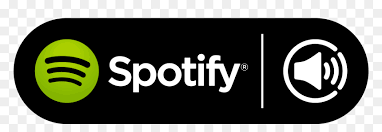

En esta notebook se realizará un motor de Recomendación de Canciones a partir de una base de datos pequeña de spotify.
Empezaré con un EDA para saber como utilizar el dataset. Luego ya que tenga entienda la base la ajustare al problema para que pueda ser mas facil de utilizarla.

# **Librerias**

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\virtual_env\Sonia\SoniaM\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

from yellowbrick.target import FeatureCorrelation

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import difflib

import json

import warnings
warnings.filterwarnings("ignore")

# **Leemos los Datos**

In [3]:
data = pd.read_csv("spotify_tracks.csv")

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741672 entries, 0 to 8741671
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   id                object 
 2   disc_number       int64  
 3   duration          float64
 4   explicit          int64  
 5   audio_feature_id  object 
 6   name              object 
 7   preview_url       object 
 8   track_number      int64  
 9   popularity        int64  
 10  is_playable       float64
 11  valence           float64
 12  acousticness      float64
 13  danceability      float64
 14  energy            float64
 15  instrumentalness  float64
 16  liveness          float64
 17  loudness          float64
 18  speechiness       float64
 19  tempo             float64
 20  key               float64
 21  mode              float64
dtypes: float64(13), int64(5), object(4)
memory usage: 1.4+ GB
None


Vamos a comprobar todos los parametros con la columna **'popularidad'**. Antes de ir a hacer eso vamos a comprobar la Correlación de Características considerando algunas características y para eso, voy a utilizar el paquete **yellowbrick**. Puedes aprender más sobre él en la página [documentation](https://www.scikit-yb.org/en/latest/index.html).

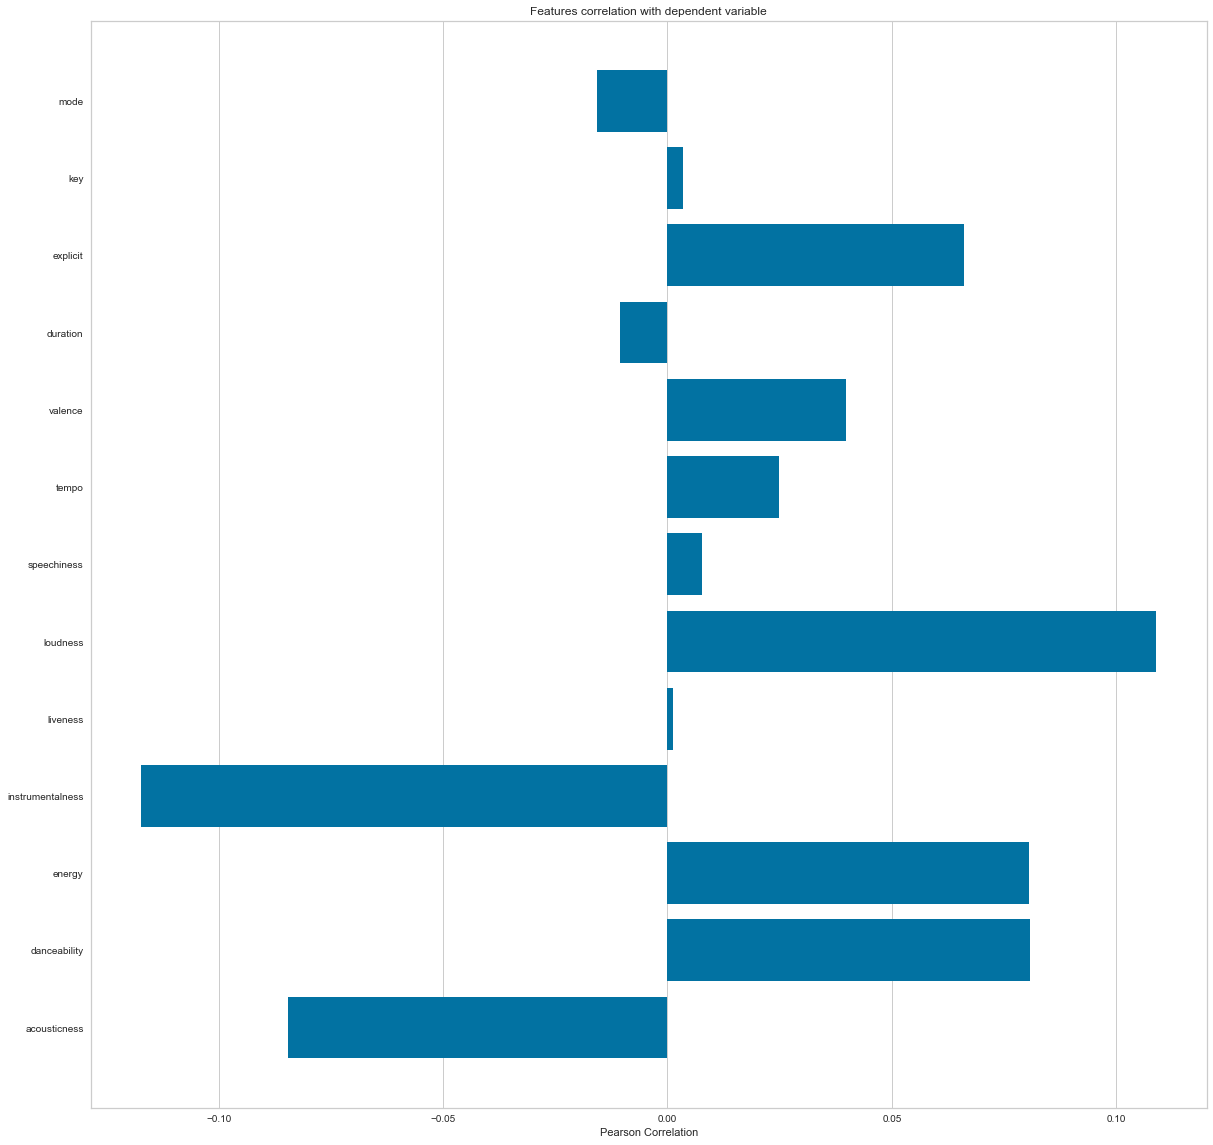

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [5]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration','explicit','key','mode']

X, y = data[feature_names], data['popularity']

# Creamos una lista con los nombres de las caracteristicas
features = np.array(feature_names)

# Creamos la instancia
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)
visualizer.show()

En estadística, el coeficiente de correlación de Pearson es una medida de dependencia lineal entre dos variables aleatorias cuantitativas. A diferencia de la covarianza, la correlación de Pearson es independiente de la escala de medida de las variables.

De manera menos formal, podemos definir el coeficiente de correlación de Pearson como un índice que puede utilizarse para medir el grado de relación de dos variables siempre y cuando ambas sean cuantitativas y continuas. 

# **Agrupación de canciones con K-Means**

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))
                                 ], verbose=False)

number_cols = ['valence', 'acousticness', 'danceability', 'duration', 'energy', 'explicit',
'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

#number_cols = ['valence', 'danceability', 'energy', 'explicit',
#               'key', 'liveness', 'loudness', 'popularity', 'speechiness', 'tempo']

#number_cols = [ 'danceability',  'energy', 'explicit', 'loudness', 'popularity', 'tempo','valence']

#number_cols = [ 'danceability',  'energy', 'explicit', 'loudness', 'popularity', 'tempo']

X = data[number_cols]
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

# **Construcción del Motor de recomendación**

* Según el análisis y las visualizaciones, está claro que los géneros similares tienden a tener puntos de datos que se ubican cerca unos de otros, mientras que los tipos de canciones similares también se agrupan.
* Esta observación tiene mucho sentido. Los géneros similares sonarán de manera similar y provendrán de períodos de tiempo similares, mientras que lo mismo puede decirse de las canciones dentro de esos géneros. Podemos usar esta idea para construir un sistema de recomendación tomando los puntos de datos de las canciones que un usuario ha escuchado y recomendando canciones correspondientes a puntos de datos cercanos.
* [Spotipy](https://spotipy.readthedocs.io/en/2.16.1/) es un cliente de Python para la API web de Spotify que facilita a los desarrolladores la obtención de datos y la consulta de canciones en el catálogo de Spotify. Tienes que instalar usando `pip install spotipy`
* Después de instalar Spotipy, deberá crear una aplicación en la [página del desarrollador de Spotify] (https://developer.spotify.com/) y guardar su ID de cliente y clave secreta.

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="62cfe79d83ef43c69a7ba63f9f5debda",
                                                           client_secret="88e6707695634f04a75301fcc77d7789"))

def find_song(name):
    song_data = defaultdict()
    results = sp.search(q= 'track: {}'.format(name), limit=1)
    if results['tracks']['items'] == []:
        return None
    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['explicit'] = [int(results['explicit'])]
    # song_data['duration'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]
    # song_data['loudness'] = [results['loudness']]
    # song_data['danceability'] = [results['danceability']]
    # song_data['energy'] = [results['energy']]
    # song_data['tempo'] = [results['tempo']]
    list_of_dict_values = list(results.values())
    results_string = json.dumps(list_of_dict_values)
    index_release_date = results_string.find("release_date")
    year_index1 = index_release_date + 16
    year_index2 = index_release_date + 17
    year_index3 = index_release_date + 18
    year_index4 = index_release_date + 19
    year_string = results_string[year_index1] + results_string[year_index2] + results_string[year_index3] + results_string[year_index4]
    print(year_string)
    
    song_data['year'] = [int(year_string)]
    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)


In [ ]:
def get_song_data(song, spotify_data):
    
  #  try:
  #      song_data = spotify_data[(spotify_data['name'] == song['name'])].iloc[0]
  #      print(song['name'], ': si esta')
  #      return song_data
    
  #  except IndexError:
    print(song['name'], ': no esta')
    return find_song(song['name'])
        

def get_mean_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=5):
    metadata_cols = ['id','name','artists']
    song_dict = flatten_dict_list(song_list)
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols]

In [ ]:
recommend_songs([{'name': 'Lobo Domesticado'}],  data)

* Esta última celda te dará una lista de recomendación de canciones

* Puedes cambiar la lista de canciones según tu elección.